In [1]:
knitr::opts_chunk$set(echo = TRUE)

In [2]:
library(grDevices)
library(dplyr)
library(tidyr)
library(ggplot2)
setwd("../")
permutations <- read.csv("permutations.csv", row.names = NULL)
permutations_tomato <- read.csv("permutations_tomato.csv", row.names = NULL)
permutations_apple <- read.csv("permutations_apple.csv", row.names = NULL)
data_black <- read.csv("processed_results/aggregated_measurements_black.csv", row.names = NULL)
data_yellow <- read.csv("processed_results/aggregated_measurements_yellow.csv", row.names = NULL)
data_avg_r <- read.csv("processed_results/aggregated_measurements_rgb.csv", row.names = NULL)
squish <- read.csv("processed_results/squish.csv", row.names = NULL)
squish$banana <- gsub("banana_", "", squish$X)
squish$pct_squished <- squish$squish
measurements <- merge(data_avg_r,
                      merge(data_black, data_yellow, by = c("banana", "trt")),
                      by = c("banana", "trt"))
measurements <- merge(measurements, squish[, c("banana", "pct_squished")])
measurements$avg_rgb <- measurements$avg_rgb_day_5 - measurements$avg_rgb_day_1
measurements$pct_brown <- measurements$pct_brown_day_5 - measurements$pct_brown_day_1

GREEN <- "#12b30c"
BROWN <- "#4a4d09"
YELLOW <- "#f2db2c"
PVAL_BLUE <- "#0726f0"
n_bananas <- 36
title_size <- 16
text_size <- 14
plot_theme <- theme(panel.background = element_blank(),
                    axis.text = element_text(size = text_size),
                    axis.title = element_text(size = title_size),
                    legend.text = element_text(size = text_size),
                    legend.title = element_text(size = title_size),
                    strip.text = element_text(size = text_size))

stat_cols <- colnames(permutations)[!grepl("(banana|permutation)", colnames(permutations))]
true_test_statistics <- mapply(
  function(stat) {
    if (grepl("apple$", stat)) {
      trt <- "A"
      stat <- gsub("_apple", "", stat)
    } else if (grepl("tomato$", stat)) {
      trt <- "T"
      stat <- gsub("_tomato", "", stat)
    } else {
      stop("Did not encounter a valid treatment level")
    }
    mean(measurements[measurements$trt == trt, stat]) - mean(measurements[measurements$trt == "C", stat])
  },
  stat_cols,
  USE.NAMES = TRUE
)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Results
No permutation test yielded a significant p-value. The two smallest p-values
came from the tests for the squish ratio test statistic: the permutation test of
the bananas in the control environment and the bananas stored with apples returned a
p-value of 0.24, and the permutation test of the control bananas and the bananas
stored with tomatoes returned a p-value of 0.27. Using the percentage of brown
spots test statistic, the test of the tomato treatment yielded a p-value of .382,
and the test of the apple treatment yielded an even larger p-value of .906. The tests
using average red channel test statistic produced the highest p-value on average
across the tests of the two treatments: the test of the tomato treatment yielded
a p-value of 0.81, and the test of the apple treatment yielded a p-value of 0.98.

Despite the overwhelmingly large p-values, visualizations of the permutation
distributions for the average red channel tests may reveal useful information about
the experimental design. The histograms below showing the
results from these permutation tests display the distribution of test statistics from
all permutations in brown, then in different shades of yellow and green,
the distribution of test statistics from permutations where each banana was
labeled as a treatment banana. For the test of the tomato treatment, each of these
"banana-specific" permutation distributions looks to have the same general shape as
the overall permutation distribution. For the test of the apple treatment, however,
there appears to be one "banana-specific" distribution whose shape differs somewhat
notably from the distribution of all the permutations, which is made clearer in
the histogram below.

In [3]:
make_all_bananas_comparison_plot <- function(perms, stat) {
  if (grepl("tomato$", stat)) {
    trt <- "T"
    clean_trt <- "Tomato"
  } else if (grepl("apple$", stat)) {
    trt <- "A"
    clean_trt <- "Apple"
  } else {
    trt <- "C"
    clean_trt <- "Control"
  }
  clean_stat <- gsub(
    "% squished", "Squish Ratio",
      gsub(
        "pct", "%", gsub(
          "avg", "Average", gsub(
            "rgb", "Red Channel", gsub(" (tomato|apple)$", "", gsub("_", " ", stat))))))
  
  banana_cols <- colnames(perms)[grepl("banana", colnames(perms))]
  pivot_data <- Reduce(
    rbind,
    lapply(banana_cols, 
          function(banana_col) {
            msk <- perms[banana_col] == trt
            banana_perms <- perms[msk,
                                  c(banana_col, colnames(perms)
                                    [!grepl("banana", colnames(perms))])]
            colnames(banana_perms)[1] <- "trt"
            cbind("Banana" = as.numeric(gsub("banana_", "", banana_col)),
                  banana_perms)
          })
  )
  pivot_data$Banana <- factor(pivot_data$Banana,
                              levels = as.numeric(gsub("banana_", "", banana_cols)))

  # running one-sided tests because trt should increase avg RGB and pct brown
  pval <- mean(perms[[stat]] >= true_test_statistics[stat])
  if (grepl("pct_brown", stat)) {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.002
    cut_val <- 0.00025
  } else if (grepl("avg_rgb", stat)) {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.01
    cut_val <- 0.0025
  } else {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.1
    cut_val <- 0.025
  }
  
  pval_label_y_val <- max(table(cut_width(perms[[stat]], width = cut_val)))
  ggplot(perms) +
    geom_histogram(aes(x = !!sym(stat)), fill = BROWN, bins=30) +
    geom_histogram(data = pivot_data,
                   aes(x = !!sym(stat), fill = Banana),
                   position = "identity", bins=30) +
    geom_vline(aes(xintercept=true_test_statistics[stat]), color = PVAL_BLUE,
               linetype="dashed") +
    scale_fill_manual(
      values = scales::seq_gradient_pal(YELLOW, GREEN)(seq(0, 1, length.out=n_bananas))) +
    labs(x = paste0(clean_stat," Test Statistic"),
         y = "N Permutations") +
    annotate("label", x = pval_label_x_val, y = pval_label_y_val,
             label = paste0("P-value: ", round(pval, 3)),
             color = PVAL_BLUE, size = 5) +
    plot_theme
}
for (r in seq_len(2)) {
  stat_col <- stat_cols[r]
  if (grepl("apple", stat_col)) {
    print(make_all_bananas_comparison_plot(permutations_apple, stat_col))
  } else if (grepl("tomato", stat_col)) {
    print(make_all_bananas_comparison_plot(permutations_tomato, stat_col))
  } else {
    stop("Did not encounter a valid stat col")
  }
}

This banana had a change in average red channel between days 1 and 5 of -0.02,
by far the lowest of all the bananas and theoretically impossible under the
monotonicity assumption underlying our decision to use average red channel as a
test statistic. This forces us to look more closely at few things, the first being
whether our method of calculating average red channel needs to be improved. Do
we need to adjust our method of calibrating the amount of light in each photo? Should
we normalize the red channel of each pixel in a photo before taking the average of
the pixels displaying the banana? Would these be possible, they should reduce the
possibility of returning a negative value for this measurement. Even if the
possibility of returning a negative value were completely removed though, this result
also makes us consider whether a difference-in-means test statistic is appropriate
for this measurement. Based on the measurements obtained in this experiment, a few
bananas lagged behind noticeably in change in average red channel, which could be
due to measurement error, or they might have been outliers. Were their lag not
to be due to measurement error, it may be more appropriate to use an
outlier-robust test statistic such as the difference-in-medians in future tests
of the average red channel measurement.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


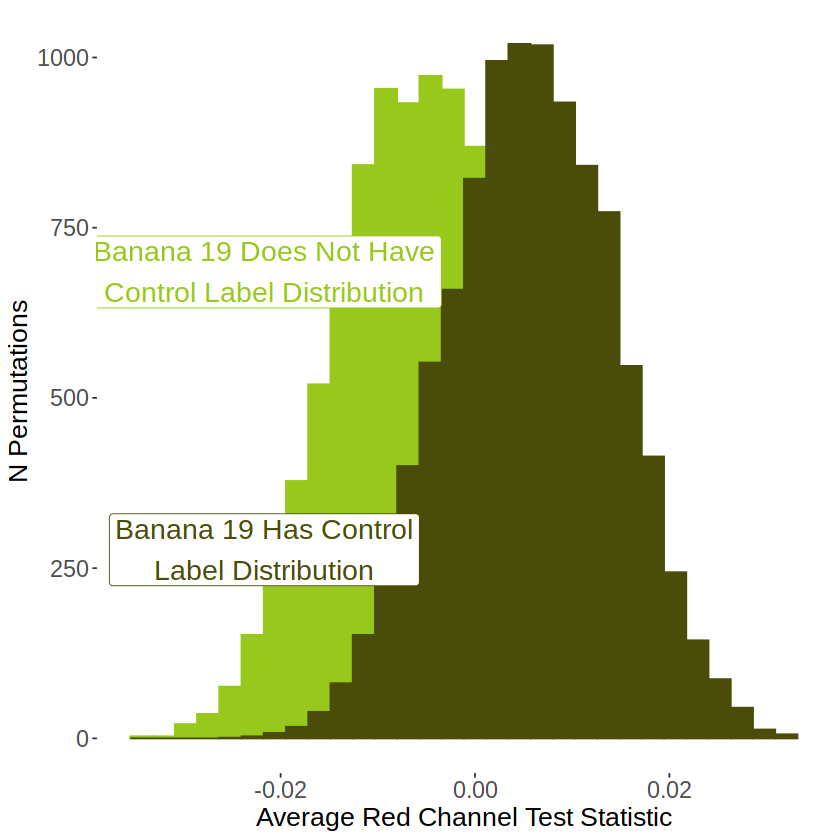

In [ ]:
make_banana_specific_comparison_plot <- function(perms, banana, stat) {
  banana_col <- paste0("banana_", banana)
  if (grepl("tomato$", stat)) {
    trt <- "T"
    clean_trt <- "Tomato"
  } else if (grepl("apple$", stat)) {
    trt <- "A"
    clean_trt <- "Apple"
  } else {
    trt <- "C"
    clean_trt <- "Control"
  }
  clean_stat <- gsub(
    "% squished", "Squish Ratio",
       gsub(
         "pct", "%", gsub(
           "avg", "Average", gsub(
             "rgb", "Red Channel", gsub(" (tomato|apple)$", "", gsub("_", " ", stat))))))

  ctrl_data <- data.frame(
    "trt" = perms[[banana_col]][perms[banana_col] == "C"],
    "perm_val" = perms[[stat]][perms[banana_col] == "C"]
  )
  trt_data <- data.frame(
    "trt" = perms[[banana_col]][perms[banana_col] == trt],
    "perm_val" = perms[[stat]][perms[banana_col] == trt]
  )
  legend_x_val <- min(quantile(ctrl_data[["perm_val"]], 0.03),
                      quantile(trt_data[["perm_val"]], 0.03))
  if (grepl("pct_brown", stat)) {
    cut_val <- 0.00025
  } else if (grepl("avg_rgb", stat)) {
    cut_val <- 0.0015
  } else {
    cut_val <- 0.025
  }
  
  legend_y_val_banana <- max(table(cut_width(ctrl_data[["perm_val"]], width = cut_val)))
  legend_y_val_all <- max(table(cut_width(trt_data[["perm_val"]], width = cut_val))) - 400
  fill_col <- scales::seq_gradient_pal(YELLOW, GREEN)(seq(0, 1, length.out=n_bananas))[banana]
  
  ggplot(ctrl_data) +
    geom_histogram(data = trt_data,
                   aes(x = perm_val), fill = fill_col, color = fill_col, bins=30) +
    geom_histogram(aes(x = perm_val), fill = BROWN, color = BROWN, bins=30) +
    annotate("label", x = legend_x_val, y = legend_y_val_banana,
             label = paste0("Banana ", banana, " Does Not Have\nControl Label Distribution"),
             color = fill_col, size = 6) +
    annotate("label", x = legend_x_val, y = legend_y_val_all,
             label = paste0("Banana ", banana, " Has Control\nLabel Distribution"),
             color = BROWN, size = 6) +
    labs(x = paste0(clean_stat," Test Statistic"),
         y = "N Permutations") +
    plot_theme
}

make_banana_specific_comparison_plot(permutations_apple, 19, "avg_rgb_apple")